In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc("font", family='Microsoft YaHei')

# 读取数据
samples_data_Bearing1_1 = pd.read_csv('./数据集预处理/samples_data_Bearing1_1.csv')
samples_data_Bearing1_2 = pd.read_csv('./数据集预处理/samples_data_Bearing1_2.csv')
samples_data_Bearing1_3 = pd.read_csv('./数据集预处理/samples_data_Bearing1_3.csv')

print(samples_data_Bearing1_3.shape)
samples_data_Bearing1_3.head()

(158, 14)


,Kurtosis,Fractal Dimension,Peak factor,Pulse factor,Crest factor,Energy ratio,Spectral flatness,Mean,Variance,Skewness,Peak vibration,Rms vibration,used_time,rul
0,-0.018922,0.609623,4.018646,5.029431,4.018646,0.259269,0.657274,-0.024847,0.244873,0.023867,1.991117,0.495470,0.006329,0.993671
1,0.034688,0.612596,4.341418,5.446060,4.341418,0.275181,0.668585,-0.009828,0.238535,0.005586,2.120781,0.488500,0.012658,0.987342
2,0.071580,0.607146,4.355396,5.476214,4.355396,0.247454,0.669986,-0.013385,0.246402,0.021185,2.162755,0.496569,0.018987,0.981013
3,0.011665,0.607159,4.285077,5.367199,4.285077,0.268315,0.664220,-0.005333,0.247482,0.003606,2.131844,0.497504,0.025316,0.974684
4,0.008824,0.603567,3.929223,4.923679,3.929223,0.262756,0.672394,-0.011985,0.259410,0.019776,2.001798,0.509464,0.031646,0.968354


### 可视化 Bearing1_3 最后一列为 目标预测值！

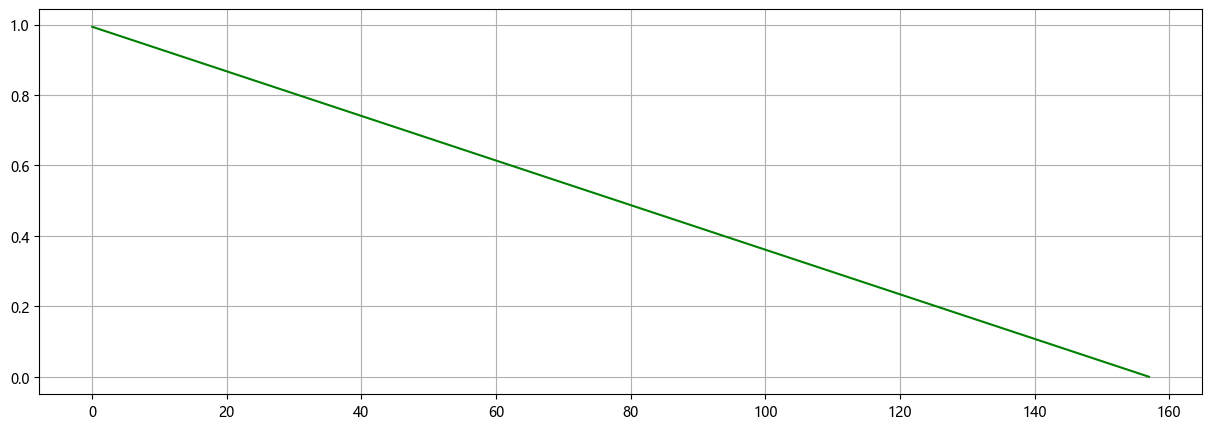

In [2]:
import pandas as pd
import datetime

# 取剩余寿命
ruldata = samples_data_Bearing1_3['rul'].tolist()
# 可视化
plt.figure(figsize=(15,5), dpi=100)
plt.grid(True)
plt.plot(ruldata, color='green')
plt.show()

In [3]:
samples_data_Bearing1_3.columns

Index(['Kurtosis', 'Fractal Dimension', 'Peak factor', 'Pulse factor',
       'Crest factor', 'Energy ratio', 'Spectral flatness', 'Mean', 'Variance',
       'Skewness', 'Peak vibration', 'Rms vibration', 'used_time', 'rul'],
      dtype='object')

分析数据： 多变量预测（输入是所有变量，这里为什么加入used_time, 因为预测一个数据，为什么其历史数据不能用？当然根据具体的任务情景来定）
1. 输入训练集  变量： 'Kurtosis', 'Fractal Dimension', 'Peak factor', 'Pulse factor',
       'Crest factor', 'Energy ratio', 'Spectral flatness', 'Mean', 'Variance',
       'Skewness', 'Peak vibration', 'Rms vibration', 'used_time'
2. 对应y值标签为：  'rul'

In [5]:
# 制作数据集和标签
import torch
import numpy as np
import pandas as pd
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 1. 输入训练集  变量：
var_data1 = samples_data_Bearing1_1[['Kurtosis', 'Fractal Dimension', 'Peak factor', 'Pulse factor',
       'Crest factor', 'Energy ratio', 'Spectral flatness', 'Mean', 'Variance',
       'Skewness', 'Peak vibration', 'Rms vibration', 'used_time']].values
var_data2 = samples_data_Bearing1_2[['Kurtosis', 'Fractal Dimension', 'Peak factor', 'Pulse factor',
       'Crest factor', 'Energy ratio', 'Spectral flatness', 'Mean', 'Variance',
       'Skewness', 'Peak vibration', 'Rms vibration', 'used_time']].values

# 测试集变量
var_data3 = samples_data_Bearing1_3[['Kurtosis', 'Fractal Dimension', 'Peak factor', 'Pulse factor',
       'Crest factor', 'Energy ratio', 'Spectral flatness', 'Mean', 'Variance',
       'Skewness', 'Peak vibration', 'Rms vibration', 'used_time']].values



# 2. 对应y值标签为： 
ylable_data1 =  samples_data_Bearing1_1[['rul']].values
ylable_data2 =  samples_data_Bearing1_2[['rul']].values
ylable_data3 =  samples_data_Bearing1_3[['rul']].values

# 归一化处理
# 使用标准化（z-score标准化）
scaler = StandardScaler()
var_data1 = scaler.fit_transform(var_data1)
var_data2 = scaler.fit_transform(var_data2)
var_data3 = scaler.fit_transform(var_data3)


# 这些转换是为了将数据和标签转换为PyTorch可以处理的张量
def make_data_labels(x_data, y_label):
    '''
        返回 x_data: 数据集     torch.tensor
            y_label: 对应标签值  torch.tensor
    '''
    # 信号值
    x_data = torch.tensor(x_data).float()
    # 标签值
    y_label = torch.tensor(y_label).float()
    return x_data, y_label


# 通过滑动窗口制作预测数据集
def create_sliding_window(x_var, ylable_data, window_size):
    '''
        参数:
        x_var            : 输入数据
        ylable_data      : 目标变量
        window_size      : 样本窗口大小
        
        返回:
        X           : 特征数据
        y           : 标签数据
    '''
    # 用来存放输入特征， 标签
    X, y = [], []
    # 滑动窗口制作数据集
    for i in range(len(x_var) - window_size):
        input_window = x_var[i:(i+window_size), :]
        output_window = ylable_data[i+window_size]
        X.append(input_window)
        y.append(output_window)
    
    # 将列表转换为单一的NumPy数组
    X = np.array(X)
    y = np.array(y)

    # 转换为 tensor
    X, y = make_data_labels(X, y)

    return X, y



# 定义滑动窗口大小
window_size = 7    # 自己定义


# 第二步 制作数据集
# Bearing1_1 、 Bearing1_2 作为训练集
train_set1, train_label1 = create_sliding_window(var_data1, ylable_data1, window_size)
train_set2, train_label2 = create_sliding_window(var_data2, ylable_data2, window_size)


# 在第一个维度上拼接
train_X = torch.cat((train_set1, train_set2), dim=0)
train_y = torch.cat((train_label1, train_label2), dim=0)

# 测试集
test_X, test_y = create_sliding_window(var_data3, ylable_data3, window_size)

# 保存数据
dump(train_X, './dataresult/train_X') 
dump(train_y, './dataresult/train_y') 
dump(test_X, './dataresult/test_X') 
dump(test_y, './dataresult/test_y')

['./dataresult/test_y']

In [6]:
print('数据 形状：')
print(train_X.size(), train_y.size())
print(test_X.size(), test_y.size())
# 变量 序列长度为 10 , 预测一个 值 （单步预测）

数据 形状：
torch.Size([270, 7, 13]) torch.Size([270, 1])
torch.Size([151, 7, 13]) torch.Size([151, 1])
